In [12]:
path = 'data/GrowthProfilerResults_Long_Pretest.csv'

In [5]:
import pandas as pd

In [13]:
df=pd.read_csv(path)

/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_27111/4099896630.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Time', y='OD600', hue='Media', style='Condition', ci='sd')


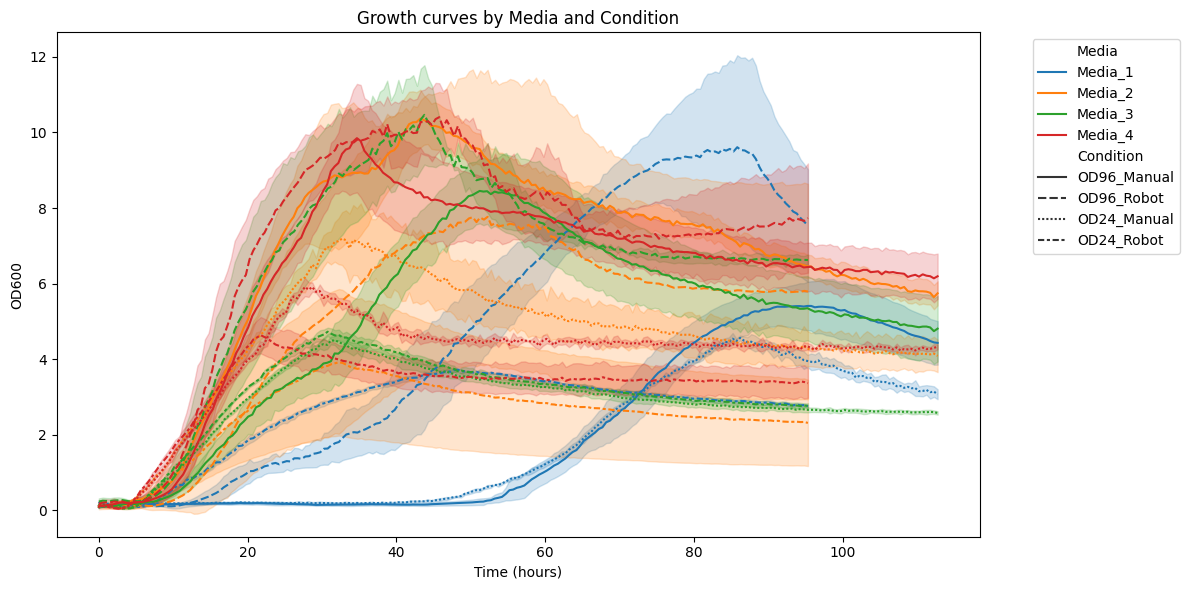

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Time', y='OD600', hue='Media', style='Condition', ci='sd')
plt.title('Growth curves by Media and Condition')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import f_oneway

# Let's look at final OD600 (last time point) per condition
final_time = df['Time'].max()
subset = df[df['Time'] == final_time]

# Example: one-way ANOVA within a single condition
cond_df = subset[subset['Condition'] == 'OD96_Robot']

f_stat, p_val = f_oneway(
    *[group['OD600'].values for name, group in cond_df.groupby('Media')]
)

print(f"ANOVA for OD96_robot at final time:")
print(f"F = {f_stat:.3f}, p = {p_val:.4e}")


TypeError: At least two samples are required; got 0.

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Just use final OD600 for this example
model_df = subset.copy()

# Convert to categorical
model_df['Media'] = model_df['Media'].astype('category')
model_df['Condition'] = model_df['Condition'].astype('category')

# Fit model
model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=model_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                    sum_sq    df          F        PR(>F)
Media            23.242943   3.0  24.154370  4.386659e-09
Condition        28.480011   1.0  88.790397  1.042172e-11
Media:Condition   0.908447   3.0   0.944070  4.284464e-01
Residual         12.830221  40.0        NaN           NaN


In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=model_df['OD600'], groups=model_df['Media'] + "_" + model_df['Condition'], alpha=0.05)
print(tukey.summary())


TypeError: unsupported operand type(s) for +: 'Categorical' and 'str'

In [15]:
import statsmodels.formula.api as smf

# Example: fit mixed model
# Assuming each unique replicate is identified (e.g., by combining Media + Replicate + Condition)

df['Subject'] = df['Media'] + "_" + df['Replicate'].astype(str) + "_" + df['Condition']

model = smf.mixedlm("OD600 ~ Time * Media * Condition", df, groups=df["Subject"])
result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            OD600      
No. Observations:            16578              Method:                        REML       
No. Groups:                  78                 Scale:                         3.3616     
Min. group size:             191                Log-Likelihood:                -33792.8555
Max. group size:             226                Converged:                     Yes        
Mean group size:             212.5                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.794    0.529  -1.500 0.134 -1.830  0.243
Media[T.Media_2]          